# Using 2657 tournament matches of Hikaru Nakamura to train a chess engine
This notebook trains a deep neural network with 2657 tournament matches of the top player H. Nakamura to play chess.

## 1 Overview
The following figure shows the basic structure of this network. 

It consists out of convolutional layers and one pooling layer and takes a feature map of the size $7 \times 8 \times 8$ as input.
The input is passed through multiple convolutional layers and a pooling layer to condense the input feature map to an output of the size $4 \times 4 \times 4$, which represents an PGN-like move.

<img src="assets/Model.svg">

In [2]:
import chess.pgn
import torch
import numpy as np
import os, os.path
import timeit

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from adabelief_pytorch import AdaBelief

from util import *

device = torch.device("cuda")

## 2 Loading the games
We use 2657 recorded tournament games of Hikaru Nakamura in the PGN format to train our network. The games are loaded as an python-chess game object to enable a better analysis of the current position like legal-moves etc.

In [4]:
# loading the games
DIR = 'data/Raw_game/Raw_game/Nakamura/'
games = []
numberOfGames = 0
start = timeit.default_timer()
for name in os.listdir(DIR):
    numberOfGames += 1
    games.append(chess.pgn.read_game(open(DIR+name)))
stop = timeit.default_timer()
print("Loaded", numberOfGames, "games in", stop - start, "seconds.")

Loaded 2657 games in 8.054068229999984 seconds.


## 3 Datastructure

### 3.1 Board

Chess is a pretty cool, but computational complexe game. There are 400 different positions after each player makes one move apiece and 72,084 positions after two. In order to create a datastructure and a neural network, that works with every possible position, we need to think a bit out of the box.
Luckily, convolutional neural networks (**CNNs**) are here to save the day.

Convolutional neural networks take an matrix like input tensor as their input and output an matrix like input. This behaviour is pretty useful, if you take a look at the chess board underneath. We can see, that a chess board is nothing but a $8 \times 8$ matrix filled with some pieces. Hence, we can create an 7 channel input tensor with the size $7 \times 8 \times 8$, where every channel represents a piece.

To get a bit of an intuition for this approach, consider the following example:

Headers(Event='Corus A', Site='Wijk aan Zee NED', Date='2010.01.27', Round='10', White='Dominguez Perez, L.', Black='Nakamura, Hi', Result='1/2-1/2', BlackElo='2708', ECO='B36', EventCategory='19', EventCountry='NED', EventDate='2010.01.16', EventRounds='13', PlyCount='139', Source='Mark Crowther', SourceDate='2010.02.01', WhiteElo='2712')


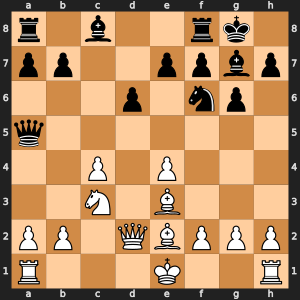

In [19]:
board = games[0].board()
count = 0
for move in games[0].mainline_moves():
    count += 1
    board.push(move)
    if count >= 20:
        break
print(games[0].headers)
chess.svg.board(board, size=300)

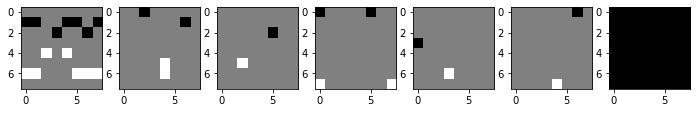

In [16]:
boardMap = boardToTensor(board, "b")[0]
fig = plt.figure(figsize=(12,7))
figNo = 1
for i in range(7):
    fig.add_subplot(1,7, figNo)
    plt.imshow(boardMap[i], cmap="gray")
    figNo += 1
plt.show()

The above example is taken from a game between Deminguez Perez, L. (white) and Nakamura, Hi. (black) in the year 2010.

If you compare the chess board to the plot underneath, you can see, that it represents the position of every pice on the board split by channels. Here is a graphic explaining the mapping of the datastructure.

<img src="assets/Board.svg">

### 3.2 PGN-Moves

You might now that there is some kind of coordinate system in chess. It is used to describe moves in the *Portable Game Notation* (**PGN**), in which almost every tournament game is documented. 

At it's core, it is a four letter string indicating the moved piece by it's coordinate (e.g. The *d2* pawn in the starting position) and the destination (e.g. *d2* pawn to *d4*).
There are a total of $4096$ possible moves, that can be notated with the *Portable Game Notation*, altough not every move is possible. This broad range of moves can easily be represented by either the right amount of output neurons (where every neuron represents one move) or, like the input, as a matrix-like tensor. I choose the matrix-like approach.

Every move consists a four channel $8 \times 8$ matrix. Since the coordinate system used in chess uses letters, we need to map these to a specific number. The board consists of $8 \times 8$ square, hence there are numbers from $1 \dots 8$ and letters from $a \dots h$.

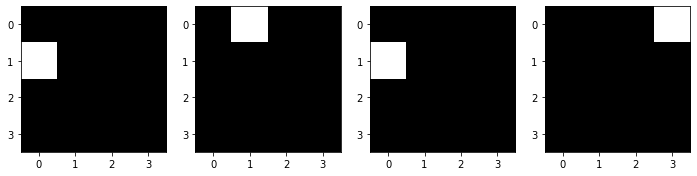

In [5]:
moveMap = moveToTensor("e2e4")
fig = plt.figure(figsize=(12,4))
figNo = 1
for i in range(4):
    fig.add_subplot(1,4, figNo)
    plt.imshow(moveMap[i], cmap="gray")
    figNo += 1
plt.show()

## Preparing the data for training

In [127]:
X, Y = [], []
for i in range(50):
    c = ""
    t = "w"
    board = games[i].board()
    
    # get the color
    if games[i].headers["White"] == "Nakamura, Hi":
        c = "w"
    else:
        c = "b"
    
    for move in games[i].mainline_moves():
        if t == c:
            X.append(boardToTensor(board, c).to(device))
            Y.append(moveToTensor(move).to(device))
            board.push(move)
            t = "a"
        else:
            board.push(move)
            t = c

## Model

In [178]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(7, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = torch.nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = torch.nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv4 = torch.nn.Conv2d(256, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv5 = torch.nn.Conv2d(128, 4, kernel_size = 3, stride = 1, padding = 1)
        
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = F.max_pool2d(torch.relu(self.conv2(x)), (2,2))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        return torch.softmax(x.view(4,16),dim=1).view(4,4,4)

In [ ]:
model = Net().to(device)
optimizer = AdaBelief(model.parameters(), lr=1e-3, eps=1e-8, betas=(0.9,0.999), weight_decouple = True, rectify = False)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
loss_function = nn.MSELoss()

## Training

In [181]:
for i in range(100):
    j=0
    for x, y in zip(X,Y):
        optimizer.zero_grad()
        #print(x, y)
        y_pred = model(x)
        
        single_loss = loss_function(y_pred, y)
        single_loss.backward()
        optimizer.step()
    print(f"Epoch: {i}. Loss: {single_loss.item()}", end="\r")
    #writer.add_scalar('Loss/train', single_loss.item(), i)

## Evaluation

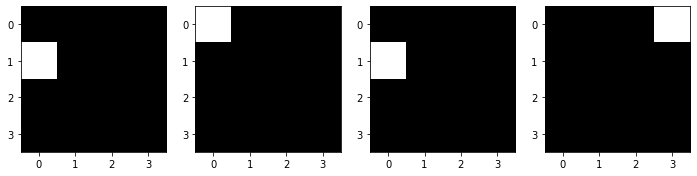

In [201]:
fig = plt.figure(figsize=(12,4))
figNo = 1
for i in range(4):
    fig.add_subplot(1,4, figNo)
    plt.imshow(Y[106][i].cpu(), cmap="gray")
    figNo += 1
plt.show()

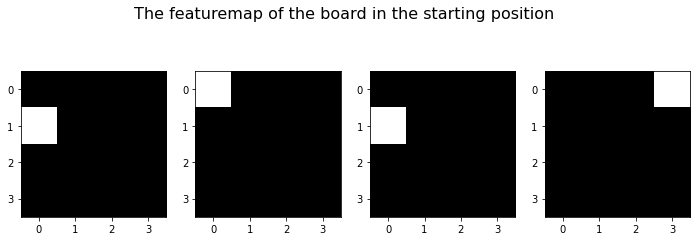

In [190]:
out = model(X[106]).detach().cpu()
fig = plt.figure(figsize=(12,4))
figNo = 1
for i in range(4):
    fig.add_subplot(1,4, figNo)
    plt.imshow(out[i], cmap="gray")
    figNo += 1
plt.show()

In [208]:
torch.save(model.state_dict(), "trained/model100Games.pt") # saving the model